In [41]:
import numpy as np 
import pandas as pd 
import zipfile
import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.resnet import ResNet50, preprocess_input
import keras
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Lambda, Dropout, InputLayer, Input

In [2]:
zip_files = ['test', 'train']
# Will unzip the files so that you can see them..
for zip_file in zip_files:
    with zipfile.ZipFile("../input/dogs-vs-cats-redux-kernels-edition/{}.zip".format(zip_file),"r") as z:
        z.extractall("temp")
        print("{} unzipped".format(zip_file))

test unzipped
train unzipped


In [3]:
train_images = os.listdir("./temp/train")
test_images = os.listdir("./temp/test")
categories = []
for filenames in train_images:
    if 'dog' in filenames:
        categories.append(str(1))
    else:
        categories.append(str(0))
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
print(df.head())

        filename category
0   cat.3824.jpg        0
1    cat.880.jpg        0
2  dog.11515.jpg        1
3  dog.10751.jpg        1
4   dog.7591.jpg        1


In [4]:
os.getcwd()

'/kaggle/working'

In [ ]:
#  os.chdir('./train/')

In [5]:
train_df, valid_df = train_test_split(df, test_size=0.25)

In [6]:
train_df.head()

,filename,category
17621,dog.11021.jpg,1
6656,cat.5690.jpg,0
12787,dog.8739.jpg,1
8587,dog.2547.jpg,1
1516,cat.5479.jpg,0


In [9]:
#To create ImageDataGenerator
def datagen(model, isTrain = False, isValid = False, isTest = False):
    
    if isTrain:
        if model == 'resnet':
            print('Working on Resnet Train Generator')
            train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                               rotation_range = 15,
                                               zoom_range = 0.1,
                                               horizontal_flip = True,
                                               fill_mode = 'nearest',
                                               width_shift_range = 0.1,
                                               height_shift_range = 0.1)
        else:
            print('Working on Vanilla Train Generator')
            train_datagen = ImageDataGenerator(rescale = 1./255,
                                               rotation_range = 15,
                                               zoom_range = 0.1,
                                               fill_mode = 'nearest',
                                               horizontal_flip = True,
                                               width_shift_range = 0.1,
                                               height_shift_range = 0.1)
            
        train_set = train_datagen.flow_from_dataframe(train_df,
                                                      './temp/train',
                                                      x_col = 'filename',
                                                      y_col = 'category',
                                                      target_size = (224,224),
                                                      batch_size = 32,
                                                      class_mode = 'binary')
        return train_set
    
    if isValid:
        if model == 'resnet':
            print('Working on Resnet Valid Generator')
            valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
        else:
            print('Working on Vanilla Valid Generator')
            valid_datagen = ImageDataGenerator(rescale = 1./255)
        valid_set = valid_datagen.flow_from_dataframe(valid_df,
                                                      './temp/train',
                                                      x_col = 'filename',
                                                      y_col = 'category',
                                                      target_size = (224,224),
                                                      batch_size = 32,
                                                      class_mode = 'binary')
        return valid_set 
    
    if isTest:
        if model == 'resnet':
            print('Working on Resnet TestGenerator')
            test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
        else:
            print('Working on Vanilla TestGenerator')
            test_datagen = ImageDataGenerator(rescale = 1./255)
        
        test_set = test_datagen.flow_from_directory('./temp/test',
                                                    
                                                    target_size = (224,224),
                                                    batch_size = 32,
                                                   )
            
#         test_set = test_datagen.flow_from_dataframe(test_df,
#                                                     './test',
#                                                     x_col = 'filename',
#                                                     y_col = None,
#                                                     target_size = (224,224),
#                                                     batch_size = 32,
#                                                     shuffle = False,
#                                                     class_mode = None)

In [10]:
train_gen = datagen(model = 'others',isTrain = True)
valid_gen = datagen(model = 'others',isValid = True)

Working on Vanilla TrainGenerator
Found 18750 validated image filenames belonging to 2 classes.
Working on Vanilla ValidGenerator
Found 6250 validated image filenames belonging to 2 classes.


In [144]:
# test_gen = datagen(model = 'others', isTest = True)
# res_test_gen = datagen(model = 'resnet', isTest = True)

In [145]:
# type(test_gen)

In [15]:
model_scratch=Sequential()
model_scratch.add(Conv2D(16, (3,3), activation="relu", input_shape=(224, 224, 3)))
model_scratch.add(Conv2D(16, (3,3), activation="relu"))
model_scratch.add(MaxPooling2D((3,3)))

model_scratch.add(Conv2D(32, (3,3), activation="relu"))
model_scratch.add(Conv2D(32, (3,3), activation="relu"))
model_scratch.add(MaxPooling2D(2,2))

model_scratch.add(Conv2D(64, (3,3), activation="relu"))
model_scratch.add(Conv2D(64, (3,3), activation="relu"))
model_scratch.add(Conv2D(64, (3,3), activation="relu"))
model_scratch.add(MaxPooling2D(2,2))
# model_scratch.add(Dropout(0.3))

model_scratch.add(Conv2D(128, (3,3), activation="relu"))
model_scratch.add(Conv2D(128, (3,3), activation="relu"))
model_scratch.add(Conv2D(128, (3,3), activation="relu"))
model_scratch.add(MaxPooling2D((2,2)))

model_scratch.add(Flatten())
model_scratch.add(Dense(1024, activation = "relu"))
model_scratch.add(Dense(256, activation = "relu"))
model_scratch.add(Dense(32, activation = "relu"))
model_scratch.add(BatchNormalization())
model_scratch.add(Dropout(0.4))
model_scratch.add(Dense(1, activation = "sigmoid"))

In [16]:
model_scratch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1

In [17]:
opt = keras.optimizers.Adam(learning_rate = 0.001)
model_scratch.compile(loss="binary_crossentropy", 
                      optimizer=opt,
                      metrics=["accuracy"])

In [18]:
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience = 10,
                          restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.1,
                                            min_lr = 0.00001)
callbacks = [earlystop, lr_reduction]

In [19]:
history_scratch = model_scratch.fit(train_gen,
                            epochs = 25,
                            validation_data = valid_gen,
                            callbacks = callbacks)

Epoch 1/25
586/586 [==============================] - 308s 526ms/step - loss: 0.6410 - accuracy: 0.6394 - val_loss: 1.6290 - val_accuracy: 0.5034
Epoch 2/25
586/586 [==============================] - 311s 530ms/step - loss: 0.5868 - accuracy: 0.7009 - val_loss: 0.5863 - val_accuracy: 0.6906
Epoch 3/25
586/586 [==============================] - 315s 537ms/step - loss: 0.5445 - accuracy: 0.7343 - val_loss: 1.0511 - val_accuracy: 0.5586
Epoch 4/25
586/586 [==============================] - 313s 535ms/step - loss: 0.5231 - accuracy: 0.7451 - val_loss: 0.5558 - val_accuracy: 0.7256
Epoch 5/25
586/586 [==============================] - 313s 534ms/step - loss: 0.4900 - accuracy: 0.7694 - val_loss: 0.4669 - val_accuracy: 0.7848
Epoch 6/25
586/586 [==============================] - 316s 539ms/step - loss: 0.4626 - accuracy: 0.7890 - val_loss: 0.4195 - val_accuracy: 0.8136
Epoch 7/25
586/586 [==============================] - 315s 538ms/step - loss: 0.4407 - accuracy: 0.8021 - val_loss: 0.8312 -

In [20]:
# hist = model_scratch.history
# acc = hist['acc']
# val_acc = hist['val_acc']
# loss = hist['loss']
# val_loss = hist['val_loss']
# epochs = len(acc)
# f, ax = plt.subplot(1,2, figsize = (14,6))
# ax[0].plot(epochs, acc, 'b', label = 'Training Accuracy')
# ax[0].legend()
# ax[1].plot(epochs, loss, 'g', label='Training loss')
# ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
# ax[1].set_title('Training and validation loss')
# ax[1].legend()
# plt.show()

In [21]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling ='max' , weights ='imagenet', input_shape = (224,224,3)))
model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False

opt = keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

94773248/94765736 [==============================] - 1s 0us/step


In [25]:
res_train_gen = datagen('resnet', isTrain = True)
res_valid_gen = datagen('resnet', isValid = True)

Working on Resnet TrainGenerator
Found 18750 validated image filenames belonging to 2 classes.
Working on Resnet ValidGenerator
Found 6250 validated image filenames belonging to 2 classes.


In [26]:
history_res = model.fit(res_train_gen,
                        epochs = 10,
                        validation_data = res_valid_gen,
                        callbacks = callbacks)

Epoch 1/10
586/586 [==============================] - 326s 557ms/step - loss: 0.4579 - accuracy: 0.9659 - val_loss: 0.0484 - val_accuracy: 0.9858
Epoch 2/10
586/586 [==============================] - 323s 551ms/step - loss: 0.0513 - accuracy: 0.9825 - val_loss: 0.0325 - val_accuracy: 0.9880
Epoch 3/10
586/586 [==============================] - 324s 553ms/step - loss: 0.0426 - accuracy: 0.9836 - val_loss: 0.0397 - val_accuracy: 0.9850
Epoch 4/10
586/586 [==============================] - 322s 549ms/step - loss: 0.0359 - accuracy: 0.9869 - val_loss: 0.0281 - val_accuracy: 0.9902
Epoch 5/10
586/586 [==============================] - 319s 545ms/step - loss: 0.0347 - accuracy: 0.9877 - val_loss: 0.0302 - val_accuracy: 0.9886
Epoch 6/10
586/586 [==============================] - 321s 549ms/step - loss: 0.0331 - accuracy: 0.9875 - val_loss: 0.0289 - val_accuracy: 0.9896
Epoch 7/10
586/586 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9873
Epoch 00007: ReduceLROnPlate

In [ ]:
# loss = pd.DataFrame(model.history.history)
# loss[['loss', 'val_loss']].plot()
# loss[['accuracy', 'val_accuracy']].plot()

In [27]:
loss, accuracy = model.evaluate_generator(res_valid_gen, res_valid_gen.samples//32, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Validation: accuracy = 0.991827  ;  loss = 0.025294 


In [121]:
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path
test_x = get_path('./temp/test')

testdf = pd.DataFrame({'filename': test_x})

In [124]:
def test_img(model):
    result_lst = []
    for path in test_sample['filename'].to_numpy():
        full_path = './temp/test/'+path
        img_array = img_to_array(load_img(full_path, target_size=(224,224)))
        img_array = np.expand_dims(img_array, axis=0)
        result = model.predict(img_array)
        result = 'dog' if float(result) > 0.5 else 'cat'
        result_lst.append(result)
    return result_lst

In [125]:
model_scratch_result = test_img(model_scratch)
model_result = test_img(model)

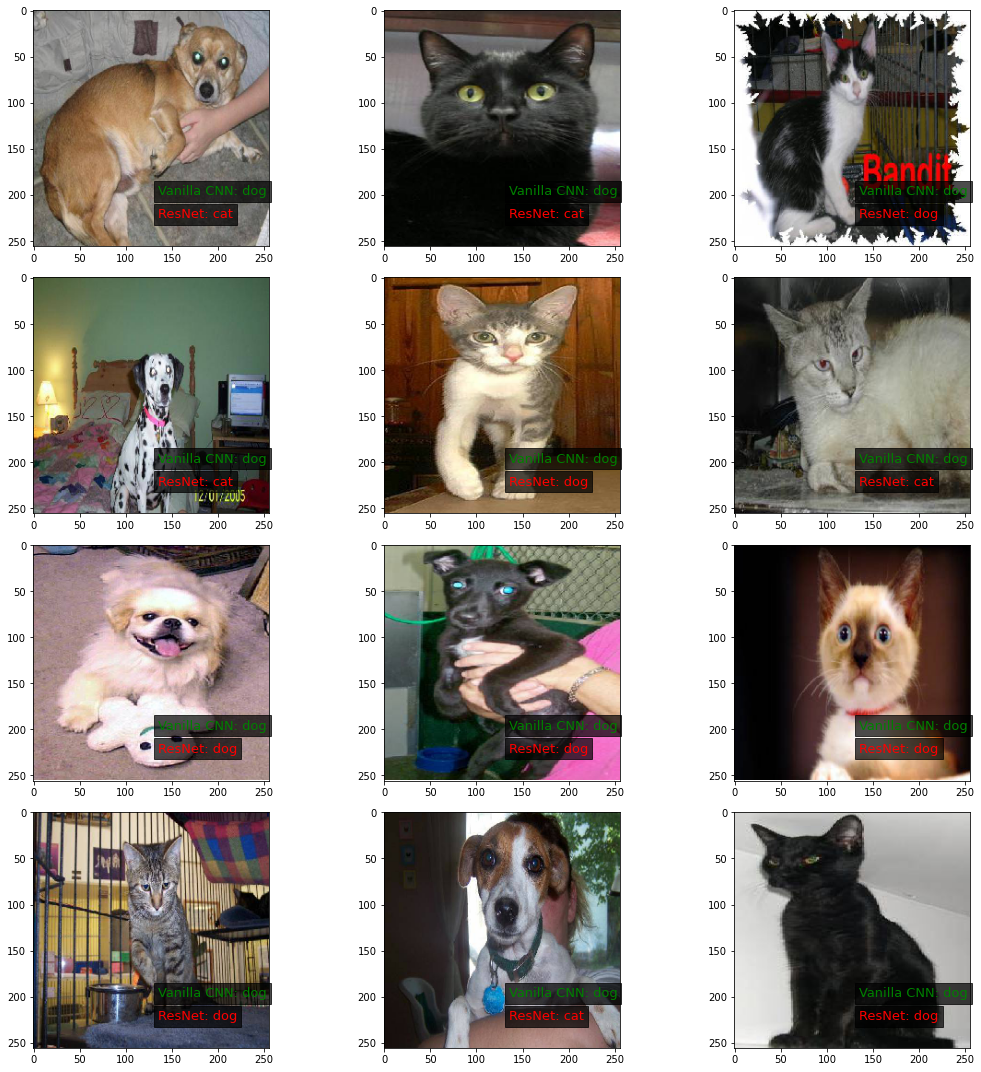

In [132]:
pred_results  = list(zip(model_scratch_result,model_result))
test_array = testdf['filename'].to_numpy()

plt.figure(figsize = (15,15))
for i in range(0,12):
    plt.subplot(4, 3, i+1)
    scratch, resmodel = pred_results[i]
    img = test_array[i]
    path = './temp/test/' + img
    image = load_img(path, target_size = (256,256))
    plt.text(135, 200, 'Vanilla CNN: {}'.format(scratch), 
             color = 'green', 
             fontsize = 13, 
             bbox = dict(facecolor = 'black', alpha = 0.7))
    plt.text(135,225, 'ResNet: {}'.format(resmodel),
            color = 'red',
            fontsize = 13,
            bbox = dict(facecolor = 'black', alpha = 0.7))
    plt.imshow(image)
plt.tight_layout()
plt.show()